# Matrix multiplication

## Set up

In [1]:
from typing import List, Callable
import matplotlib.pyplot as plt
from time import time_ns
from tqdm import tqdm
import pandas as pd
import random

import numpy as np
import numba

In [2]:
SEED = 42
random.seed(SEED)

In [3]:
PY_SIZES = [10, 20, 50, 70, 100, 200, 300, 400]
NP_SIZES = [10, 50, 100, 500, 750, 1000, 2500, 5000, 7500]
NUMBA_SIZES = [10, 50, 100, 500, 750, 1000, 1500, 2000]

In [4]:
def create_python_matrix(n):
    A_py = [[random.random() for _ in range(n)] for _ in range(n)]
    B_py = [[random.random() for _ in range(n)] for _ in range(n)]
    C_py = [[0.0 for _ in range(n)] for _ in range(n)]

    return A_py, B_py, C_py

def create_numpy_matrix(n):
    A_np = np.random.random_sample((n, n))
    B_np = np.random.random_sample((n, n))
    C_np = np.empty_like(A_np)

    return A_np, B_np, C_np

In [5]:
def benchmark(
    mult_func: Callable[[int], int],
    matrix_gen_func: Callable[[int], int],
    sizes: List[int],
    nb_repeat: int = 1
) -> np.ndarray:
    times = np.zeros((len(sizes), nb_repeat))

    for i, size in enumerate(tqdm(sizes)):
        for j in range(nb_repeat):
            A, B, C = matrix_gen_func(size)
            
            t0 = time_ns()
            mult_func(A, B, C)
            times[i, j] = time_ns() - t0

    return times

In [6]:
def compute_metrics(times: np.ndarray) -> np.ndarray:
    # Function to compute the mean, standard deviation and median of the times
    metrics = np.zeros((times.shape[0], 3))

    for i in range(times.shape[0]):
        metrics[i, 0] = np.mean(times[i])
        metrics[i, 1] = np.std(times[i])
        metrics[i, 2] = np.median(times[i])

    return metrics

In [7]:
# Datastructure to store the functions, their names, the steps and the results
matrix_mul_df = pd.DataFrame(columns=['name', 'matmul_func', 'matcrea_func', 'sizes', 'times', 'metrics'])

## Native Python matrix multiplication

In [8]:
def multi_matrix_naive(A, B, C):
    for k in range(len(A[0])):
        for i in range(len(A)):
            t = A[i][k]
            for j in range(len(B[0])):
                C[i][j] += t * B[k][j]
    return C


In [9]:
matrix_mul_df.loc[0] = {
    'name': 'Naive python',
    'matmul_func': multi_matrix_naive,
    'matcrea_func': create_python_matrix,
    'sizes': PY_SIZES,
    'times': None,
    'metrics': None
}

## Numpy matrix dot-product

In [10]:
def multi_matrix_dot(A, B, C):
    C = np.dot(A, B)
    return C

In [11]:
matrix_mul_df.loc[1] = {
    'name': 'Numpy dot',
    'matmul_func': multi_matrix_dot,
    'matcrea_func': create_numpy_matrix,
    'sizes': NP_SIZES,
    'times': None,
    'metrics': None
}

## Numpy matrix multiplication

In [12]:
def multi_matrix_np(A, B, C):
    C = np.matmul(A, B)
    return C

In [13]:
matrix_mul_df.loc[2] = {
    'name': 'Numpy matmul',
    'matmul_func': multi_matrix_np,
    'matcrea_func': create_numpy_matrix,
    'sizes': NP_SIZES,
    'times': None,
    'metrics': None
}

## Code to compare the different implementations

In [14]:
# Benchmark and plot code
for i, row in matrix_mul_df.loc[:2].iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['matmul_func'], row['matcrea_func'], row['sizes'], nb_repeat=1)
    row['metrics'] = compute_metrics(row['times'])

Benchmarking Naive python method


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Benchmarking Numpy dot method


100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Benchmarking Numpy matmul method


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


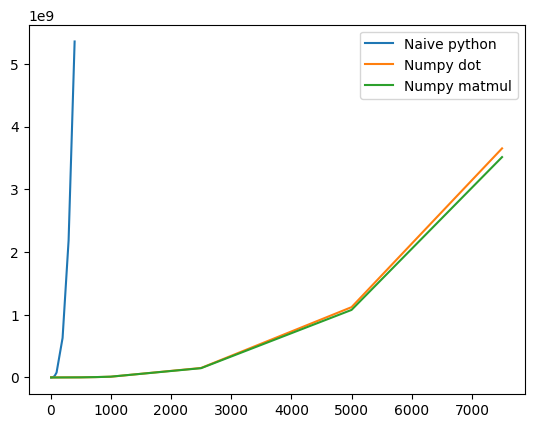

In [15]:
for i, row in matrix_mul_df.loc[:2].iterrows():
    plt.plot(row['sizes'], row['times'], label=row['name'])
plt.legend()

## Numba implementation

In [16]:
@numba.jit(nopython = True)
def multi_matrix_numba(A: List[List[float]], B: List[List[float]], C: List[List[float]]):
    for k in range(len(A[0])):
        for i in range(len(A)):
            t = A[i][k]
            for j in range(len(B[0])):
                C[i][j] += t * B[k][j]
    return C

In [17]:
matrix_mul_df.loc[3] = {
    'name': 'Numba python',
    'matmul_func': multi_matrix_numba,
    'matcrea_func': create_numpy_matrix,
    'sizes': NUMBA_SIZES,
    'times': None,
    'metrics': None
}

Compare your implementations with/without Numba

In [18]:
# Benchmark and plot code
row = matrix_mul_df.loc[3]
print(f"Benchmarking {row['name']} method")
row['times'] = benchmark(row['matmul_func'], row['matcrea_func'], row['sizes'], nb_repeat=1)
row['metrics'] = compute_metrics(row['times'])

Benchmarking Numba python method


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


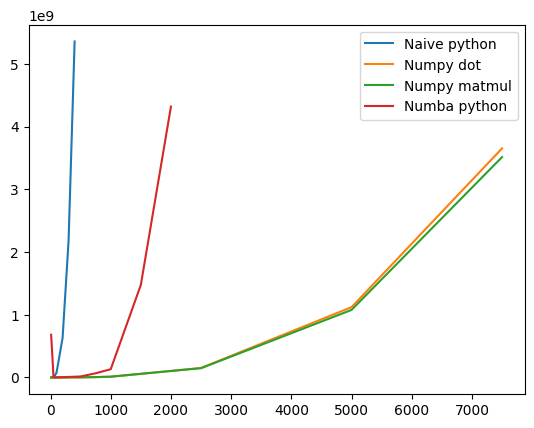

In [19]:
for i, row in matrix_mul_df.loc[:3].iterrows():
    plt.plot(row['sizes'], row['times'], label=row['name'])
plt.legend()

## Implementation to test with float (32) and double (64) floating point numbers

In [20]:
def create_np64_matrix(n):
    A_np = np.random.random_sample((n, n)).astype(np.float64)
    B_np = np.random.random_sample((n, n)).astype(np.float64)
    C_np = np.empty_like(A_np).astype(np.float64)

    return A_np, B_np, C_np

def create_np32_matrix(n):
    A_np = np.random.random_sample((n, n)).astype(np.float32)
    B_np = np.random.random_sample((n, n)).astype(np.float32)
    C_np = np.empty_like(A_np).astype(np.float32)

    return A_np, B_np, C_np

##### Bonus: Numpy with half (16) floating point numnbers #####
def create_np16_matrix(n):
    A_np = np.random.random_sample((n, n)).astype(np.float16)
    B_np = np.random.random_sample((n, n)).astype(np.float16)
    C_np = np.empty_like(A_np).astype(np.float16)

    return A_np, B_np, C_np

In [21]:
matrix_mul_df.loc[4] = {
    'name': 'Numpy float64',
    'matmul_func': multi_matrix_np,
    'matcrea_func': create_np64_matrix,
    'sizes': NP_SIZES,
    'times': None,
    'metrics': None
}

matrix_mul_df.loc[5] = {
    'name': 'Numpy float32',
    'matmul_func': multi_matrix_np,
    'matcrea_func': create_np32_matrix,
    'sizes': NP_SIZES,
    'times': None,
    'metrics': None
}

matrix_mul_df.loc[6] = {
    'name': 'Numpy float16',
    'matmul_func': multi_matrix_np,
    'matcrea_func': create_np16_matrix,
    'sizes': [10, 50, 100, 500, 750, 850],
    'times': None,
    'metrics': None
}

### Float32 - Float64 comparison

In [22]:
# Benchmark and plot code
for i, row in matrix_mul_df.loc[4:].iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['matmul_func'], row['matcrea_func'], row['sizes'], nb_repeat=1)
    row['metrics'] = compute_metrics(row['times'])

Benchmarking Numpy float64 method


100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Benchmarking Numpy float32 method


100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Benchmarking Numpy float16 method


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


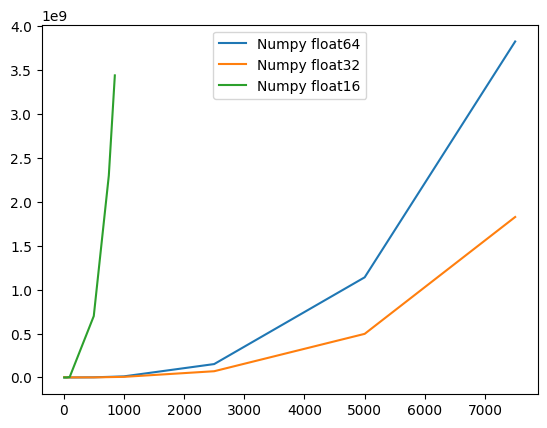

In [23]:
for i, row in matrix_mul_df.loc[4:].iterrows():
    plt.plot(row['sizes'], row['times'], label=row['name'])
plt.legend()

## Bonus: Matrix multiplication with torch tensors

In [44]:
import torch

def multi_matrix_torch(A: torch.Tensor, B: torch.Tensor, C: torch.Tensor):
    C = torch.matmul(A, B)
    return C

In [45]:
def create_tensor64_matrix(n):
    A_torch = torch.rand(n, n).type(torch.float64).to('cuda:0')
    B_torch = torch.rand(n, n).type(torch.float64).to('cuda:0')
    C_torch = torch.empty_like(A_torch).type(torch.float64).to('cuda:0')

    return A_torch, B_torch, C_torch

def create_tensor32_matrix(n):
    A_torch = torch.rand(n, n).type(torch.float32).to('cuda:0')
    B_torch = torch.rand(n, n).type(torch.float32).to('cuda:0')
    C_torch = torch.empty_like(A_torch).type(torch.float32).to('cuda:0')

    return A_torch, B_torch, C_torch

In [46]:
matrix_mul_df.loc[7] = {
    'name': 'Torch float64',
    'matmul_func': multi_matrix_torch,
    'matcrea_func': create_tensor64_matrix,
    'sizes': [1000, 2000, 3000, 4000, 6000, 7000, 8000, 9000, 10000],
    'times': None,
    'metrics': None
}

matrix_mul_df.loc[8] = {
    'name': 'Torch float32',
    'matmul_func': multi_matrix_torch,
    'matcrea_func': create_tensor32_matrix,
    'sizes': [1000, 2000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    'times': None,
    'metrics': None
}

In [47]:
# Benchmark and plot code
torch.cuda.empty_cache()
for i, row in matrix_mul_df.loc[7:].iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['matmul_func'], row['matcrea_func'], row['sizes'], nb_repeat=1)
    torch.cuda.empty_cache()
    row['metrics'] = compute_metrics(row['times'])

Benchmarking Torch float64 method


100%|██████████| 9/9 [00:23<00:00,  2.63s/it]


Benchmarking Torch float32 method


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


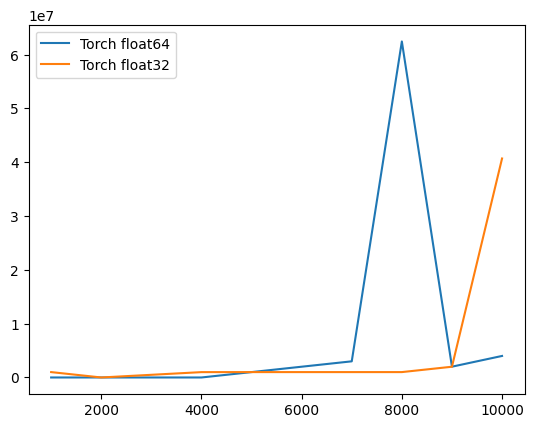

In [48]:
for i, row in matrix_mul_df.loc[7:].iterrows():
    plt.plot(row['sizes'], row['times'], label=row['name'])
plt.legend()

Improve your implementations using Cython

Compare your implementation with/without Cython